In [1]:
import pathlib
import torch
import torch.utils.data
import torchvision
import torch.nn as nn

from torchvision import datasets, tv_tensors
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from Loader_17 import normalize
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from deform_video import DeformLightVideoPos, RefineLightPos
from deform_model import get_batch_average_bou_iou
from polygon import RasLoss, SoftPolygon
import torch.optim as optim
import cv2 as cv
from preprocess_utensils import get_boundary_points, uniform_sample_points
import gc

In [2]:
coco_val_img_path = pathlib.Path("./coco/val2017")
coco_val_ann_path = pathlib.Path("./coco/annotations/instances_val2017.json")


In [3]:
val_dataset = datasets.CocoDetection(coco_val_img_path, coco_val_ann_path)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


In [4]:
sample = val_dataset[0]
img, target = sample
print(img.size, len(target), target[0].keys(), type(img))

(640, 426) 20 dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id']) <class 'PIL.Image.Image'>


In [5]:
wrap_val_dataset = datasets.wrap_dataset_for_transforms_v2(val_dataset, target_keys=["masks"])


In [6]:
sample = wrap_val_dataset[0]
img, target = sample
print(img.size, len(target), target.keys(), type(img), target["masks"].unique(), )

(640, 426) 1 dict_keys(['masks']) <class 'PIL.Image.Image'> tensor([0, 1], dtype=torch.uint8)


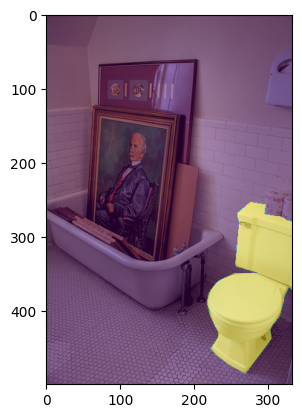

<class 'PIL.Image.Image'> <class 'torchvision.tv_tensors._mask.Mask'>


In [7]:
rand_idx = random.randint(0, len(wrap_val_dataset))
img, target = wrap_val_dataset[rand_idx]
rand_mask_idx = random.randint(0, len(target["masks"]) - 1)
mask = target["masks"]
plt.imshow(img)
plt.imshow(mask[rand_mask_idx], alpha=0.5)
plt.show()
print(type(img), type(mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6336956].


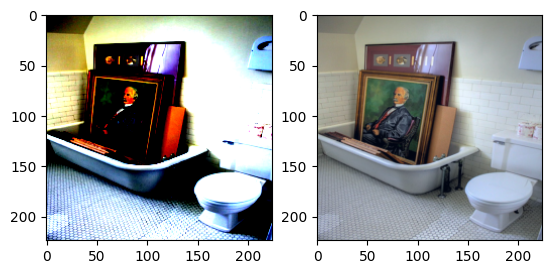

In [8]:
img_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
resize_img = img_transform(img)
plt.subplot(1, 2, 1)
plt.imshow(resize_img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(normalize(resize_img).permute(1, 2, 0))

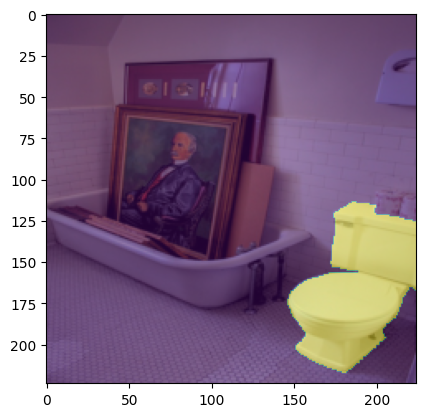

<class 'torchvision.tv_tensors._mask.Mask'> <class 'torchvision.tv_tensors._mask.Mask'>


In [9]:
mask_transform = v2.Compose(
    [
        v2.Resize((224, 224), interpolation="nearest"),
    ]
)
resize_mask = mask_transform(mask)
plt.imshow(normalize(resize_img.permute(1, 2, 0)))
plt.imshow(resize_mask[rand_mask_idx], alpha=0.5)
plt.show()
print(type(resize_mask), type(mask))

In [10]:
type(img), type(resize_mask)

(PIL.Image.Image, torchvision.tv_tensors._mask.Mask)

In [11]:
affine_transformer = v2.RandomAffine(degrees=(-70, 70), translate=(0.1, 0.3), scale=(0.5, 0.75), shear=(-30, 30))
affine_img, affine_mask = affine_transformer(resize_img, resize_mask)

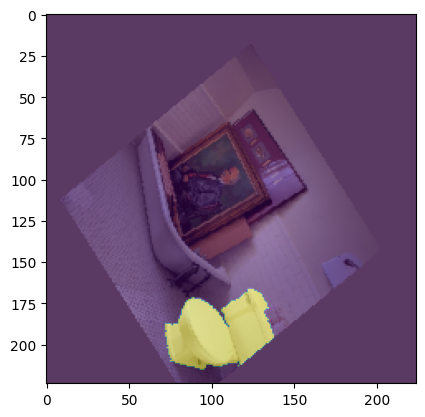

In [12]:
plt.imshow(normalize(normalize(affine_img).permute(1, 2, 0)))
plt.imshow(affine_mask[rand_mask_idx], alpha=0.5)
plt.show()

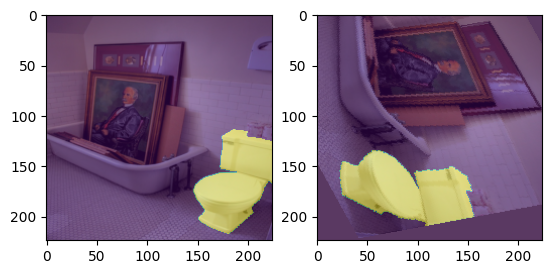

In [13]:
big_affiner = v2.RandomAffine(degrees=(-70, 70), translate=(0.1, 0.3), scale=(0.5, 1.5), shear=30)
big_affine_img, big_affine_mask = big_affiner(resize_img, resize_mask)
plt.subplot(1, 2, 1)
plt.imshow(normalize(resize_img).permute(1, 2, 0))
plt.imshow(resize_mask[rand_mask_idx], alpha=0.5)
plt.subplot(1, 2, 2)
plt.imshow(normalize(big_affine_img).permute(1, 2, 0))
plt.imshow(big_affine_mask[rand_mask_idx], alpha=0.5)
plt.show()

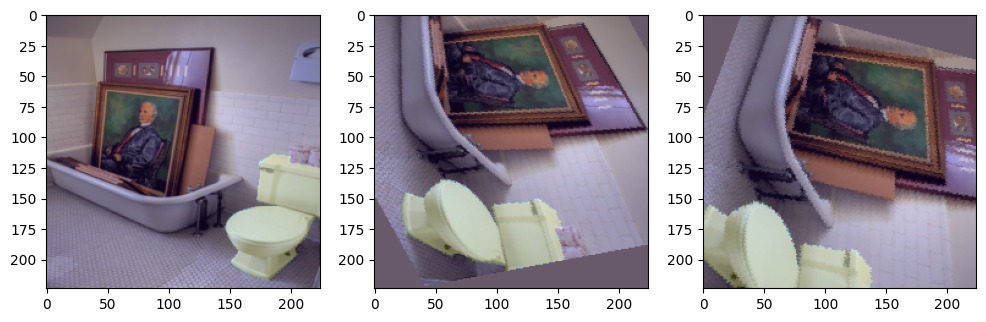

In [14]:
small_affiner = v2.RandomAffine(degrees=(-20, 20), translate=(0.05, 0.15), scale=(0.9, 1.4), shear=10)
small_affine_img, small_affine_mask = small_affiner(big_affine_img, big_affine_mask)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(normalize(resize_img).permute(1, 2, 0))
plt.imshow(resize_mask[rand_mask_idx], alpha=0.2)
plt.subplot(1, 3, 2)
plt.imshow(normalize(big_affine_img).permute(1, 2, 0))
plt.imshow(big_affine_mask[rand_mask_idx], alpha=0.2)
plt.subplot(1, 3, 3)
plt.imshow(normalize(small_affine_img).permute(1, 2, 0))
plt.imshow(small_affine_mask[rand_mask_idx], alpha=0.2)
plt.show()

In [15]:
type(img), type(mask)

(PIL.Image.Image, torchvision.tv_tensors._mask.Mask)

In [16]:
class PreTransformer:
    def __init__(self) -> None:
        self.img_transform = v2.Compose(
            [
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Resize((224, 224)),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        self.mask_transform = v2.Compose(
            [
                v2.Resize((224, 224), interpolation="nearest"),
            ]
        )

    def __call__(
        self, img: Image.Image, mask: tv_tensors.Mask
    ) -> tuple[tv_tensors.Image, tv_tensors.Mask]:
        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        return img, mask


# pre_transformer = PreTransformer()
# rand_idx = random.randint(0, len(wrap_val_dataset) - 1)
# sample = wrap_val_dataset[rand_idx]
# img, target = sample
# mask = target["masks"]
# rand_mask_idx = random.randint(0, len(target["masks"]) - 1)
# resized_img, resized_mask = pre_transformer(img, mask)
# plt.imshow(normalize(resized_img).permute(1, 2, 0))
# plt.imshow(resized_mask[rand_mask_idx], alpha=0.5)

In [ ]:
# rand_idx = random.randint(0, len(wrap_val_dataset) - 1)
# sample = wrap_val_dataset[rand_idx]
# img, target = sample
# mask = target["masks"]
# rand_mask_idx = random.randint(0, len(target["masks"]) - 1)
# resized_img, resized_mask = pre_transformer(img, mask)
# pre_frame_img, pre_frame_mask = resized_img, resized_mask
# cur_frame_img, cur_frame_mask = resized_img, resized_mask

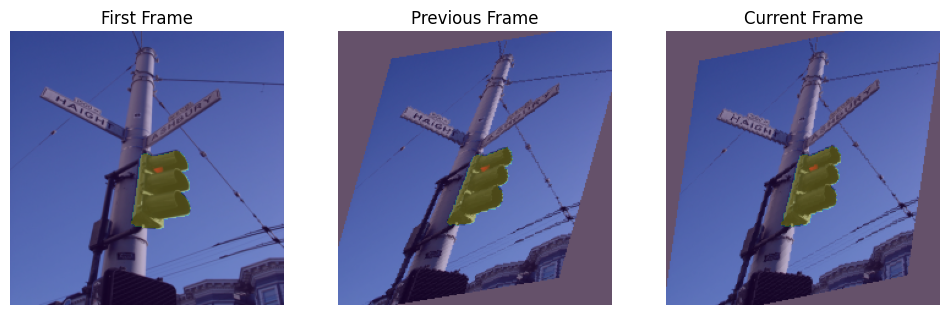

In [297]:
# shift_angle = random.uniform(-30, 30)
# shift_translate = (random.uniform(0.1, 0.3), random.uniform(0.1, 0.3))
# shift_scale = random.uniform(0.5, 1.5)
# shift_shear = random.uniform(-30, 30)
# pre_frame_img= v2.functional.affine(resized_img, angle=shift_angle, translate=shift_translate, scale=shift_scale, shear=shift_shear)
# pre_frame_mask = v2.functional.affine(resized_mask, angle=shift_angle, translate=shift_translate, scale=shift_scale, shear=shift_shear)

# next_shift_angle = shift_angle + random.uniform(-10, 10)
# next_shift_translate = (shift_translate[0] + random.uniform(-0.05, 0.05), shift_translate[1] + random.uniform(-0.05, 0.05))
# next_shift_scale = shift_scale + random.uniform(-0.1, 0.1)
# next_shift_shear = shift_shear + random.uniform(-10, 10)
# cur_frame_img = v2.functional.affine(resized_img, angle=next_shift_angle, translate=next_shift_translate, scale=next_shift_scale, shear=next_shift_shear)
# cur_frame_mask = v2.functional.affine(resized_mask, angle=next_shift_angle, translate=next_shift_translate, scale=next_shift_scale, shear=next_shift_shear)

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 1)
# plt.imshow(normalize(resized_img).permute(1, 2, 0))
# plt.imshow(resized_mask[rand_mask_idx], alpha=0.3)
# plt.axis("off")
# plt.title("First Frame")
# plt.subplot(1, 3, 2)
# plt.imshow(normalize(pre_frame_img).permute(1, 2, 0))
# plt.imshow(pre_frame_mask[rand_mask_idx], alpha=0.3)
# plt.axis("off")
# plt.title("Previous Frame")
# plt.subplot(1, 3, 3)
# plt.imshow(normalize(cur_frame_img).permute(1, 2, 0))
# plt.imshow(cur_frame_mask[rand_mask_idx], alpha=0.3)
# plt.axis("off")
# plt.title("Current Frame")
# plt.show()

In [17]:
class AffineFrameGenerator:
    def __init__(self) -> None:
        self.big_shift_params = dict(
            angle=(-70, 70),
            translate=(0.1, 0.3),
            scale=(0.5, 1.5),
            shear=(-30, 30),
        )
        self.small_shift_params = dict(
            angle=(-10, 10),
            translate=(-0.05, 0.05),
            scale=(-0.1, 0.1),
            shear=(-10, 10),
        )

    def __call__(self, img: tv_tensors.Image, mask: tv_tensors.Mask) -> tuple[
        tuple[tv_tensors.Image, tv_tensors.Mask],
        tuple[tv_tensors.Image, tv_tensors.Mask],
    ]:
        shift_angle = random.uniform(*self.big_shift_params["angle"])
        shift_translate = (
            random.uniform(*self.big_shift_params["translate"]),
            random.uniform(*self.big_shift_params["translate"]),
        )
        shift_scale = random.uniform(*self.big_shift_params["scale"])
        shift_shear = random.uniform(*self.big_shift_params["shear"])
        pre_frame_img = v2.functional.affine(
            img,
            angle=shift_angle,
            translate=shift_translate,
            scale=shift_scale,
            shear=shift_shear,
        )
        pre_frame_mask = v2.functional.affine(
            mask,
            angle=shift_angle,
            translate=shift_translate,
            scale=shift_scale,
            shear=shift_shear,
        )

        next_shift_angle = shift_angle + random.uniform(
            *self.small_shift_params["angle"]
        )
        next_shift_translate = (
            shift_translate[0] + random.uniform(*self.small_shift_params["translate"]),
            shift_translate[1] + random.uniform(*self.small_shift_params["translate"]),
        )
        next_shift_scale = shift_scale + random.uniform(
            *self.small_shift_params["scale"]
        )
        next_shift_shear = shift_shear + random.uniform(
            *self.small_shift_params["shear"]
        )
        cur_frame_img = v2.functional.affine(
            img,
            angle=next_shift_angle,
            translate=next_shift_translate,
            scale=next_shift_scale,
            shear=next_shift_shear,
        )
        cur_frame_mask = v2.functional.affine(
            mask,
            angle=next_shift_angle,
            translate=next_shift_translate,
            scale=next_shift_scale,
            shear=next_shift_shear,
        )
        return (pre_frame_img, pre_frame_mask), (cur_frame_img, cur_frame_mask)


# frame_generator = AffineFrameGenerator()
# rand_idx = random.randint(0, len(wrap_val_dataset) - 1)
# sample = wrap_val_dataset[rand_idx]
# img, target = sample
# mask = target["masks"]
# rand_mask_idx = random.randint(0, len(target["masks"]) - 1)
# resized_img, resized_mask = pre_transformer(img, mask)
# (pre_frame_img, pre_frame_mask), (cur_frame_img, cur_frame_mask) = frame_generator(
#     resized_img, resized_mask
# )
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 1)
# plt.imshow(normalize(resized_img).permute(1, 2, 0))
# plt.imshow(resized_mask[rand_mask_idx], alpha=0.3)
# plt.axis("off")
# plt.title("First Frame")
# plt.subplot(1, 3, 2)
# plt.imshow(normalize(pre_frame_img).permute(1, 2, 0))
# plt.imshow(pre_frame_mask[rand_mask_idx], alpha=0.3)
# plt.axis("off")
# plt.title("Previous Frame")
# plt.subplot(1, 3, 3)
# plt.imshow(normalize(cur_frame_img).permute(1, 2, 0))
# plt.imshow(cur_frame_mask[rand_mask_idx], alpha=0.3)
# plt.axis("off")
# plt.title("Current Frame")
# plt.show()

In [18]:
class CocoPretrainDataset(Dataset):
    def __init__(
        self,
        dataset: datasets.CocoDetection,
        use_tqdm=False,
        small_subset=False,
        point_num=64,
        dataset_size=None,
    ) -> None:
        self.point_num = point_num
        self.dataset_size = dataset_size
        self.pre_transformer = PreTransformer()
        self.frame_generator = AffineFrameGenerator()
        # only keep the images with masks
        dataset = datasets.wrap_dataset_for_transforms_v2(
            dataset, target_keys=["masks"]
        )
        if small_subset:
            dataset = torch.utils.data.Subset(dataset, range(100))
        # if use_tqdm:
        #     dataset = tqdm(dataset)
        # self.dataset = [item for item in dataset if "masks" in item[1]]
        self.dataset = dataset
        self.gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()

    def __len__(self) -> int:
        if self.dataset_size is not None:
            return self.dataset_size
        else:
            return len(self.dataset)

    def __getitem__(self, idx: int) -> dict[str, torch.Tensor]:
        # randomly choose one image
        def _get_new_idx():
            while True:
                random.seed()
                idx = random.randint(0, len(self.dataset) - 1)
                sample = self.dataset[idx]
                if "masks" in sample[1]:
                    return idx

        if self.dataset_size is not None:
            idx = _get_new_idx()
        sample = self.dataset[idx]
        while "masks" not in sample[1]:
            idx = _get_new_idx()
            sample = self.dataset[idx]
        img, target = sample
        mask = target["masks"]
        resized_img, raw_resized_mask = self.pre_transformer(img, mask)

        def _get_boundary_points(mask: torch.Tensor) -> torch.Tensor:
            boundary = get_boundary_points(mask.numpy())
            boundary = uniform_sample_points(boundary, self.point_num)
            boundary = torch.tensor(boundary, dtype=torch.float32)
            return boundary

        counter = 0
        while True:
            if counter > 10:
                idx = _get_new_idx()
                sample = self.dataset[idx]
                img, target = sample
                mask = target["masks"]
                resized_img, raw_resized_mask = self.pre_transformer(img, mask)
            counter += 1
            # randomly choose one mask until we find a non-empty mask
            rand_mask_idx = random.randint(0, len(mask) - 1)
            resized_mask = tv_tensors.Mask(raw_resized_mask[rand_mask_idx])
            (pre_frame_img, pre_frame_mask), (cur_frame_img, cur_frame_mask) = (
                self.frame_generator(resized_img, resized_mask)
            )
            if cur_frame_mask.sum() > 0 and pre_frame_mask.sum() > 0:
                first_boundary = _get_boundary_points(resized_mask)
                prev_boundary = _get_boundary_points(pre_frame_mask)
                curr_boundary = _get_boundary_points(cur_frame_mask)
                if not (
                    first_boundary.shape
                    == prev_boundary.shape
                    == curr_boundary.shape
                    == (self.point_num, 2)
                ):
                    continue
                break

        cur_frame_mask = self.gt_rasterizer(
            curr_boundary.unsqueeze(0).cuda(),
            cur_frame_mask.shape[0],
            cur_frame_mask.shape[1],
        )
        cur_frame_mask[cur_frame_mask == -1] = 0
        cur_frame_mask = cur_frame_mask.squeeze(0)
        # move curr_frame_mask to the same device as curr_frame_img
        cur_frame_mask = cur_frame_mask.to(cur_frame_img.device)

        return {
            "first_img": resized_img,
            "first_mask": resized_mask,
            "first_boundary": first_boundary,
            "prev_img": pre_frame_img,
            "prev_mask": pre_frame_mask,
            "prev_boundary": prev_boundary,
            "curr_img": cur_frame_img,
            "curr_mask": cur_frame_mask,
            "curr_boundary": curr_boundary,
        }

In [19]:
my_dataset = CocoPretrainDataset(val_dataset, use_tqdm=True)

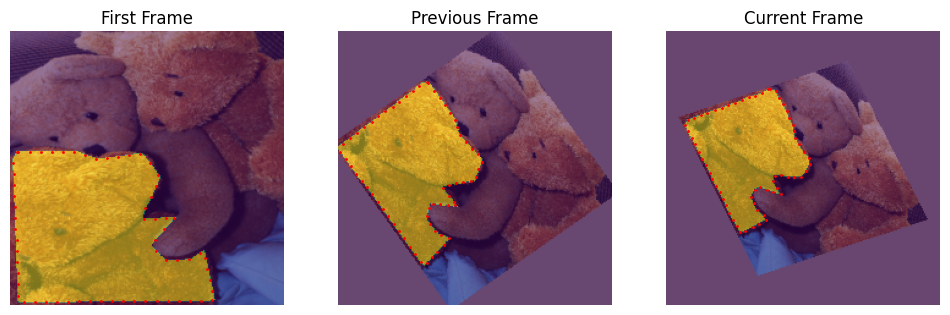

In [20]:
sample = my_dataset[4]
fir_img, fir_mask, fir_bou = sample["first_img"], sample["first_mask"], sample["first_boundary"]
pre_img, pre_mask, pre_bou = sample["prev_img"], sample["prev_mask"], sample["prev_boundary"]
cur_img, cur_mask, cur_bou = sample["curr_img"], sample["curr_mask"], sample["curr_boundary"]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(normalize(fir_img).permute(1, 2, 0))
plt.imshow(fir_mask, alpha=0.5)
plt.plot(fir_bou[:, 0], fir_bou[:, 1], "r.", markersize=2)
# plt.scatter(fir_bou[:, 0], fir_bou[:, 1], c="r")
plt.axis("off")
plt.title("First Frame")
plt.subplot(1, 3, 2)
plt.imshow(normalize(pre_img).permute(1, 2, 0))
plt.imshow(pre_mask, alpha=0.5)
plt.plot(pre_bou[:, 0], pre_bou[:, 1], "r.", markersize=2)
plt.axis("off")
plt.title("Previous Frame")
plt.subplot(1, 3, 3)
plt.imshow(normalize(cur_img).permute(1, 2, 0))
plt.imshow(cur_mask, alpha=0.5)
plt.plot(cur_bou[:, 0], cur_bou[:, 1], "r.", markersize=2)
plt.axis("off")
plt.title("Current Frame")
plt.show()

In [21]:
val_loader = DataLoader(my_dataset, batch_size=2, shuffle=True)

In [22]:
for batch in tqdm(val_loader):
    pass

  2%|██▋                                                                                                                                         | 49/2500 [00:02<01:57, 20.92it/s]


KeyboardInterrupt: 

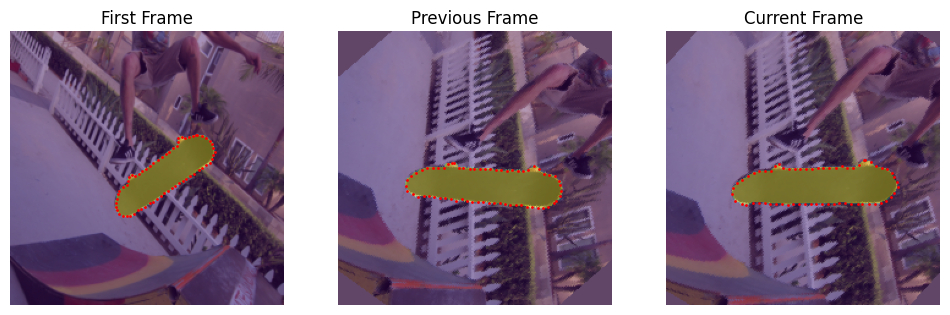

In [23]:
img_batch = next(iter(val_loader))
fir_img, fir_mask, fir_bou = img_batch["first_img"], img_batch["first_mask"], img_batch["first_boundary"]
pre_img, pre_mask, pre_bou = img_batch["prev_img"], img_batch["prev_mask"], img_batch["prev_boundary"]
cur_img, cur_mask, cur_bou = img_batch["curr_img"], img_batch["curr_mask"], img_batch["curr_boundary"]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(normalize(fir_img[0]).permute(1, 2, 0))
plt.imshow(fir_mask[0], alpha=0.4)
plt.plot(fir_bou[0][:, 0], fir_bou[0][:, 1], "r.", markersize=2)
plt.axis("off")
plt.title("First Frame")
plt.subplot(1, 3, 2)
plt.imshow(normalize(pre_img[0]).permute(1, 2, 0))
plt.imshow(pre_mask[0], alpha=0.4)
plt.plot(pre_bou[0][:, 0], pre_bou[0][:, 1], "r.", markersize=2)
plt.axis("off")
plt.title("Previous Frame")
plt.subplot(1, 3, 3)
plt.imshow(normalize(cur_img[0]).permute(1, 2, 0))
plt.imshow(cur_mask[0], alpha=0.4)
plt.plot(cur_bou[0][:, 0], cur_bou[0][:, 1], "r.", markersize=2)
plt.axis("off")
plt.title("Current Frame")
plt.show()

In [24]:
coco_train_img_path = pathlib.Path("./coco/train2017")
coco_train_ann_path = pathlib.Path("./coco/annotations/instances_train2017.json")
train_dataset = datasets.CocoDetection(coco_train_img_path, coco_train_ann_path)

loading annotations into memory...
Done (t=15.23s)
creating index...
index created!


In [25]:
my_train_dataset = CocoPretrainDataset(train_dataset, use_tqdm=True, small_subset=True)
train_loader = DataLoader(my_train_dataset, batch_size=1, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.86it/s]


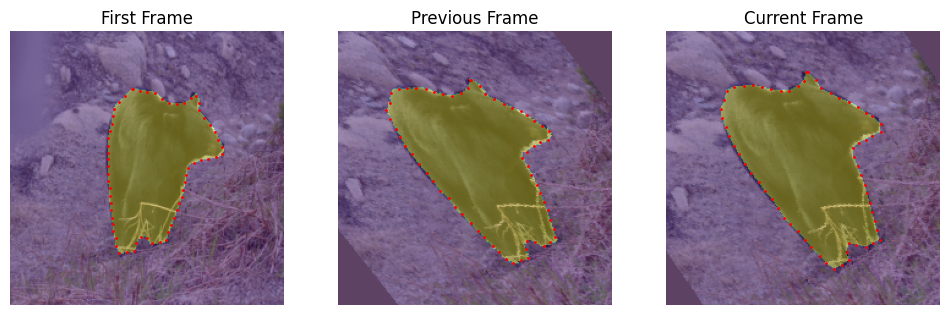

In [26]:
# test the train loader
for batch in tqdm(train_loader):
    pass
batch = next(iter(train_loader))
fir_img, fir_mask, fir_bou = batch["first_img"], batch["first_mask"], batch["first_boundary"]
pre_img, pre_mask, pre_bou = batch["prev_img"], batch["prev_mask"], batch["prev_boundary"]
cur_img, cur_mask, cur_bou = batch["curr_img"], batch["curr_mask"], batch["curr_boundary"]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(normalize(fir_img[0]).permute(1, 2, 0))
plt.imshow(fir_mask[0], alpha=0.4)
plt.plot(fir_bou[0][:, 0], fir_bou[0][:, 1], "r.", markersize=2)
plt.axis("off")
plt.title("First Frame")
plt.subplot(1, 3, 2)
plt.imshow(normalize(pre_img[0]).permute(1, 2, 0))
plt.imshow(pre_mask[0], alpha=0.4)
plt.plot(pre_bou[0][:, 0], pre_bou[0][:, 1], "r.", markersize=2)
plt.axis("off")
plt.title("Previous Frame")
plt.subplot(1, 3, 3)
plt.imshow(normalize(cur_img[0]).permute(1, 2, 0))
plt.imshow(cur_mask[0], alpha=0.4)
plt.plot(cur_bou[0][:, 0], cur_bou[0][:, 1], "r.", markersize=2)
plt.axis("off")
plt.title("Current Frame")
plt.show()

In [27]:
my_val_dataset = CocoPretrainDataset(val_dataset, use_tqdm=True, small_subset=True)
val_loader = DataLoader(my_val_dataset, batch_size=1, shuffle=True)

In [28]:
small_train_dataset = CocoPretrainDataset(train_dataset, use_tqdm=True, dataset_size=100, small_subset=False)
small_val_dataset = CocoPretrainDataset(val_dataset, use_tqdm=True, dataset_size=10, small_subset=False)
train_loader = DataLoader(small_train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(small_val_dataset, batch_size=1, shuffle=True)

In [29]:
model = DeformLightVideoPos(offset_limit=56).cuda()
ras_loss = RasLoss().cuda()
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [31]:
pred_bou = model(
    fir_img.cuda(),
    fir_bou.cuda(),
    pre_img.cuda(),
    pre_bou.cuda(),
    pre_mask.cuda(),
    cur_img.cuda(),
)
pred_bou.shape

torch.Size([1, 64, 2])

In [32]:
loss_dict = {}
iou_train_dict = {}
iou_val_dict = {}
best_val_iou = 0
eval_period = 1
epoch_num = 12

In [33]:
def get_batch_average_bou_iou(
    boundary: torch.Tensor,
    mask: torch.Tensor,
    rasterizer,
) -> torch.Tensor:
    with torch.no_grad():
        pred_sgm = rasterizer(boundary, 224, 224)
        pred_sgm[pred_sgm == -1] = 0
        pred_sgm = pred_sgm.flatten(1)
        mask = mask.flatten(1)
        intersection = pred_sgm * mask
        intersection = intersection.sum(-1)
        union = pred_sgm.sum(-1) + mask.sum(-1) - intersection
        iou = intersection / union
        result = iou.mean()
        if torch.isnan(result):
            return torch.tensor(0.0).to(iou.device)
        return result

In [34]:
gc.collect()

7883

In [35]:
for epoch in range(epoch_num):
    mean_loss = 0
    train_mean_iou = 0
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        fir_img, fir_mask, fir_bou = (
            batch["first_img"].cuda(),
            batch["first_mask"].cuda(),
            batch["first_boundary"].cuda(),
        )
        pre_img, pre_mask, pre_bou = (
            batch["prev_img"].cuda(),
            batch["prev_mask"].cuda(),
            batch["prev_boundary"].cuda(),
        )
        cur_img, cur_mask, cur_bou = (
            batch["curr_img"].cuda(),
            batch["curr_mask"].cuda(),
            batch["curr_boundary"].cuda(),
        )
        pred_bou = model(
            fir_img,
            fir_bou,
            pre_img,
            pre_bou,
            pre_mask,
            cur_img,
        )
        loss = ras_loss(pred_bou, cur_mask)
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        iou = get_batch_average_bou_iou(pred_bou, cur_mask, gt_rasterizer)
        train_mean_iou += iou.item()

    
    mean_loss /= len(train_loader)
    train_mean_iou /= len(train_loader)
    loss_dict[epoch] = mean_loss
    iou_train_dict[epoch] = train_mean_iou
    print(f"Epoch {epoch}, Train Loss: {mean_loss:.4f}, Train Mean IoU: {train_mean_iou:.4f}")

    if epoch % eval_period == 0 or epoch == epoch_num - 1:
        val_mean_iou = 0
        model.eval()
        for batch in tqdm(val_loader):
            fir_img, fir_mask, fir_bou = (
                batch["first_img"].cuda(),
                batch["first_mask"].cuda(),
                batch["first_boundary"].cuda(),
            )
            pre_img, pre_mask, pre_bou = (
                batch["prev_img"].cuda(),
                batch["prev_mask"].cuda(),
                batch["prev_boundary"].cuda(),
            )
            cur_img, cur_mask, cur_bou = (
                batch["curr_img"].cuda(),
                batch["curr_mask"].cuda(),
                batch["curr_boundary"].cuda(),
            )
            pred_bou = model(
                fir_img,
                fir_bou,
                pre_img,
                pre_bou,
                pre_mask,
                cur_img,
            )
            iou = get_batch_average_bou_iou(pred_bou, cur_mask, gt_rasterizer)
            if torch.isnan(iou):
                print("NaN IoU")
                print(pred_bou.shape)
                break
            val_mean_iou += iou.item()
        val_mean_iou /= len(val_loader)
        iou_val_dict[epoch] = val_mean_iou
        print(f"Epoch {epoch}, Val Mean IoU: {val_mean_iou:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.75it/s]


Epoch 0, Train Loss: 0.4943, Train Mean IoU: 0.3941


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch 0, Val Mean IoU: 0.3587


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]


Epoch 1, Train Loss: 0.4911, Train Mean IoU: 0.4015


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch 1, Val Mean IoU: 0.4106


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]


Epoch 2, Train Loss: 0.4004, Train Mean IoU: 0.4974


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]


Epoch 2, Val Mean IoU: 0.4562


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]


Epoch 3, Train Loss: 0.4450, Train Mean IoU: 0.4552


  0%|                                                                                                                                                       | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [13]:
model = RefineLightPos(offset_limit=56).cuda()
ras_loss = RasLoss().cuda()
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [14]:
loss_dict = {}
iou_train_dict = {}
iou_val_dict = {}
best_val_iou = 0
eval_period = 1
epoch_num = 12

In [15]:
for epoch in range(epoch_num):
    mean_loss = 0
    train_mean_iou = 0
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        fir_img, fir_mask, fir_bou = (
            batch["first_img"].cuda(),
            batch["first_mask"].cuda(),
            batch["first_boundary"].cuda(),
        )
        pre_img, pre_mask, pre_bou = (
            batch["prev_img"].cuda(),
            batch["prev_mask"].cuda(),
            batch["prev_boundary"].cuda(),
        )
        cur_img, cur_mask, cur_bou = (
            batch["curr_img"].cuda(),
            batch["curr_mask"].cuda(),
            batch["curr_boundary"].cuda(),
        )
        pred_bous = model(
            fir_img,
            fir_bou,
            pre_img,
            pre_bou,
            pre_mask,
            cur_img,
        )
        loss = 0
        for pred_bou in pred_bous:
            loss += ras_loss(pred_bou, cur_mask)
        loss /= len(pred_bous)
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        iou = get_batch_average_bou_iou(pred_bou, cur_mask, gt_rasterizer)
        train_mean_iou += iou.item()

    
    mean_loss /= len(train_loader)
    train_mean_iou /= len(train_loader)
    loss_dict[epoch] = mean_loss
    iou_train_dict[epoch] = train_mean_iou
    print(f"Epoch {epoch}, Train Loss: {mean_loss:.4f}, Train Mean IoU: {train_mean_iou:.4f}")

    if epoch % eval_period == 0 or epoch == epoch_num - 1:
        val_mean_iou = 0
        model.eval()
        for batch in tqdm(val_loader):
            fir_img, fir_mask, fir_bou = (
                batch["first_img"].cuda(),
                batch["first_mask"].cuda(),
                batch["first_boundary"].cuda(),
            )
            pre_img, pre_mask, pre_bou = (
                batch["prev_img"].cuda(),
                batch["prev_mask"].cuda(),
                batch["prev_boundary"].cuda(),
            )
            cur_img, cur_mask, cur_bou = (
                batch["curr_img"].cuda(),
                batch["curr_mask"].cuda(),
                batch["curr_boundary"].cuda(),
            )
            pred_bou = model(
                fir_img,
                fir_bou,
                pre_img,
                pre_bou,
                pre_mask,
                cur_img,
            )
            iou = get_batch_average_bou_iou(pred_bou, cur_mask, gt_rasterizer)
            val_mean_iou += iou.item()
        val_mean_iou /= len(val_loader)
        iou_val_dict[epoch] = val_mean_iou
        print(f"Epoch {epoch}, Val Mean IoU: {val_mean_iou:.4f}")

  0%|                                                                                                                                                      | 0/100 [00:00<?, ?it/s]/work3/s232248/miniconda3/envs/rass/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439764/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s]


Epoch 0, Train Loss: 0.4772, Train Mean IoU: 0.4184


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.31it/s]


Epoch 0, Val Mean IoU: 0.3190


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


Epoch 1, Train Loss: 0.4565, Train Mean IoU: 0.4388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.37it/s]


Epoch 1, Val Mean IoU: 0.7280


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


Epoch 2, Train Loss: 0.3316, Train Mean IoU: 0.5501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.48it/s]


Epoch 2, Val Mean IoU: 0.4604


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Epoch 3, Train Loss: 0.4425, Train Mean IoU: 0.4586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.60it/s]


Epoch 3, Val Mean IoU: 0.5535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Epoch 4, Train Loss: 0.4480, Train Mean IoU: 0.4399


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch 4, Val Mean IoU: 0.4332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Epoch 5, Train Loss: 0.4237, Train Mean IoU: 0.4570


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch 5, Val Mean IoU: 0.5727


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Epoch 6, Train Loss: 0.4206, Train Mean IoU: 0.4699


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.59it/s]


Epoch 6, Val Mean IoU: 0.5114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Epoch 7, Train Loss: 0.5148, Train Mean IoU: 0.3787


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch 7, Val Mean IoU: 0.4172


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Epoch 8, Train Loss: 0.4451, Train Mean IoU: 0.4500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch 8, Val Mean IoU: 0.6237


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Epoch 9, Train Loss: 0.3923, Train Mean IoU: 0.5036


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.42it/s]


Epoch 9, Val Mean IoU: 0.4012


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s]


Epoch 10, Train Loss: 0.4335, Train Mean IoU: 0.4607


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.29it/s]


Epoch 10, Val Mean IoU: 0.6022


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s]


Epoch 11, Train Loss: 0.4482, Train Mean IoU: 0.4526


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.28it/s]

Epoch 11, Val Mean IoU: 0.5745


In [22]:
iou = get_batch_average_bou_iou(pred_bou, cur_mask, gt_rasterizer)
pred_bou.shape, iou

(torch.Size([1, 64, 2]), tensor(0.4762, device='cuda:0'))

In [93]:
full_train_dataset = CocoPretrainDataset(train_dataset, use_tqdm=True, dataset_size=None)

In [94]:
full_val_dataset = CocoPretrainDataset(val_dataset, use_tqdm=True, dataset_size=None)

In [95]:
full_train_loader = DataLoader(full_train_dataset, batch_size=2, shuffle=True)
full_val_loader = DataLoader(full_val_dataset, batch_size=2, shuffle=True)

In [96]:
for batch in tqdm(full_train_loader):
    pass

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59144/59144 [45:05<00:00, 21.86it/s]


In [97]:
for batch in tqdm(full_val_loader):
    pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:57<00:00, 21.28it/s]
